This notebook loads the pandas pickle that create_df.py generates and maps each photo metadata to the 
closest edge of the Graph representing the streets of NYC. Also we double check that all the photos are inside manhattan

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import shapely.geometry as geom
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
# Load Manhattan geojson (bound for photos)
admin_df = gpd.read_file('manhattan.geojson')

In [3]:
bound = admin_df.ix[0].geometry

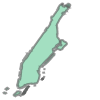

In [4]:
bound

In [5]:
# Read first batch of photos metadata
df = pd.read_pickle('photos_pickle')

In [6]:
# Read second batch of photos metadata
df2 = pd.read_pickle('new_photos_df2')

In [7]:
# Assign column names
df.columns = [['mongo_id', 'id', 'lon', 'lat', 'neigh', 'has_people', 'date', 'owner_id', 'owner_location', 'title', 'num_tags', 'tags', 'num_comments', 'description', 'views', 'date_taken', 'url']]

In [8]:
# Assign column names
df2.colums = [['mongo_id', 'id', 'lon', 'lat', 'neigh', 'has_people', 'date', 'owner_id', 'owner_location', 'title', 'num_tags', 'tags', 'num_comments', 'description', 'views', 'date_taken', 'url']]

In [9]:
df.shape

(199477, 17)

In [10]:
df2.shape

(156314, 17)

In [11]:
# Get photos with geodata
df_with_loc = df[~df.lon.isnull()].reset_index()

In [12]:
# Get photos with geodata
df_with_loc2 = df2[~df2.lon.isnull()].reset_index()

In [13]:
df_with_loc.shape

(193740, 18)

In [14]:
df_with_loc2.shape

(152709, 18)

In [29]:
# get list of geo points from df
lat_long_list = list()
for i in range(df_with_loc.shape[0]):
    row = df_with_loc.ix[i] 
    lat_long_list.append(geom.Point(row.lon, row.lat))
# convert it to geoseries
points_series= gpd.GeoSeries(lat_long_list)

In [26]:
# get list of geo points from df
lat_long_list2 = list()
for i in range(df_with_loc2.shape[0]):
    row = df_with_loc2.ix[i] 
    lat_long_list2.append(geom.Point(row.lon, row.lat))
# convert it to geoseries
points_series2= gpd.GeoSeries(lat_long_list2)

In [35]:
# Add geopoints to geoDF
df_with_loc['points_series'] = points_series
df_with_loc2['points_series'] = points_series2

In [36]:
# Filter to get only photos in Manhattan
df_manhattan = df_with_loc[points_series.within(bound)]
df_manhattan2 = df_with_loc2[points_series2.within(bound)]

In [70]:
# Concatenate both dataframes
frames = [df_manhattan, df_manhattan2]

result = pd.concat(frames)

In [72]:
# Drop a few duplicates
result = result.drop_duplicates(subset='id')

In [73]:
result.shape

(164743, 19)

In [74]:
# Save data to a pandas dataframe pickle
result.to_pickle('merged_total_mongodb')

In [5]:
# Eliminate extra photos that appear in the same post
result.tags = result.tags.astype(str)
r = result.sort_values('views', ascending=False).drop_duplicates(subset=['title', 'owner_id', 'tags'])
# Get geoseries of photos in Manhattan
points_series_man= gpd.GeoSeries(r.points_series)

In [11]:
#Iterate through photos and map them to nearest edge. Takes some hours.
import time
start = time.time()

id_list = []
for i, point in enumerate(points_series_man):
    neareast_line = np.argmin([point.distance(line) for line in df_edges.geometry])
    id_list.append(df_edges.ix[neareast_line].id)
array = np.array(id_list)
end = time.time()
end-start

9572.16240811348

In [12]:
# Add mapping to the Manhattan Dataframe
r['edges'] = array

In [91]:
# Save to pickle
r.to_pickle('df_manhattan_merged')